# Dutch Learning Analytics

Visualizations and insights from your FSRS review data.

This notebook explores:
- Learning progress over time
- Card difficulty distribution
- Forgetting curves
- Review patterns
- Problem words identification

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
from pathlib import Path
import math

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Connect to database (updated path to match FSRS persistence)
DB_PATH = Path('../logs/learning.db')
if not DB_PATH.exists():
    print(f"WARNING: Database not found at {DB_PATH}")
    print("Run the card game app first to generate review data.")
else:
    conn = sqlite3.connect(DB_PATH)
    conn.row_factory = sqlite3.Row
    print(f"✓ Connected to {DB_PATH}")

✓ Connected to ..\logs\learning.db


## Check Database Schema and Contents

Let's verify the database structure first

In [ ]:
# Check what tables exist
tables_df = pd.read_sql_query("""
    SELECT name FROM sqlite_master WHERE type='table'
""", conn)

print("Tables in database:")
print(tables_df)
print()

# Check if card_state table has any data
try:
    total_cards = pd.read_sql_query("SELECT COUNT(*) as count FROM card_state", conn)
    print(f"Total rows in card_state: {total_cards['count'][0]}")
    
    # Show all exercise types
    exercise_types = pd.read_sql_query("""
        SELECT exercise_type, COUNT(*) as count 
        FROM card_state 
        GROUP BY exercise_type
    """, conn)
    print("\nRows by exercise_type:")
    print(exercise_types)
    
    # Show sample of all cards (not filtered by exercise_type)
    sample_all = pd.read_sql_query("SELECT * FROM card_state LIMIT 5", conn)
    print("\nSample of ALL cards in database:")
    print(sample_all[['word_id', 'lemma', 'pos', 'exercise_type', 'stability', 'difficulty']] if len(sample_all) > 0 else "Empty")
    
except Exception as e:
    print(f"Error querying card_state: {e}")

print("\n" + "="*60)

# Check review_events
try:
    total_events = pd.read_sql_query("SELECT COUNT(*) as count FROM review_events", conn)
    print(f"Total rows in review_events: {total_events['count'][0]}")
    
    sample_events = pd.read_sql_query("SELECT * FROM review_events LIMIT 5", conn)
    print("\nSample of review_events:")
    print(sample_events[['lemma', 'pos', 'exercise_type', 'timestamp', 'feedback_grade']] if len(sample_events) > 0 else "Empty")
except Exception as e:
    print(f"Error querying review_events: {e}")

## 2. Stability Distribution

How well are words retained? Higher stability = longer before forgetting.

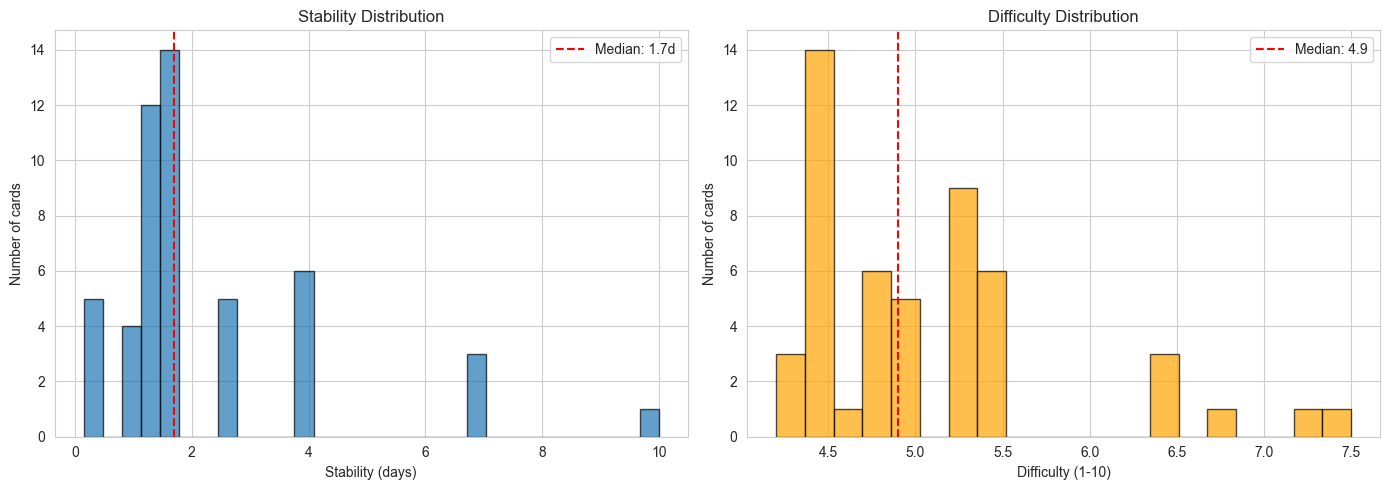

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stability distribution
ax1.hist(cards_df['stability'], bins=30, edgecolor='black', alpha=0.7)
ax1.axvline(cards_df['stability'].median(), color='red', linestyle='--', 
            label=f'Median: {cards_df["stability"].median():.1f}d')
ax1.set_xlabel('Stability (days)')
ax1.set_ylabel('Number of cards')
ax1.set_title('Stability Distribution')
ax1.legend()

# Difficulty distribution
ax2.hist(cards_df['difficulty'], bins=20, edgecolor='black', alpha=0.7, color='orange')
ax2.axvline(cards_df['difficulty'].median(), color='red', linestyle='--',
            label=f'Median: {cards_df["difficulty"].median():.1f}')
ax2.set_xlabel('Difficulty (1-10)')
ax2.set_ylabel('Number of cards')
ax2.set_title('Difficulty Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Retrievability Heatmap

Current state of all cards - which ones need review?

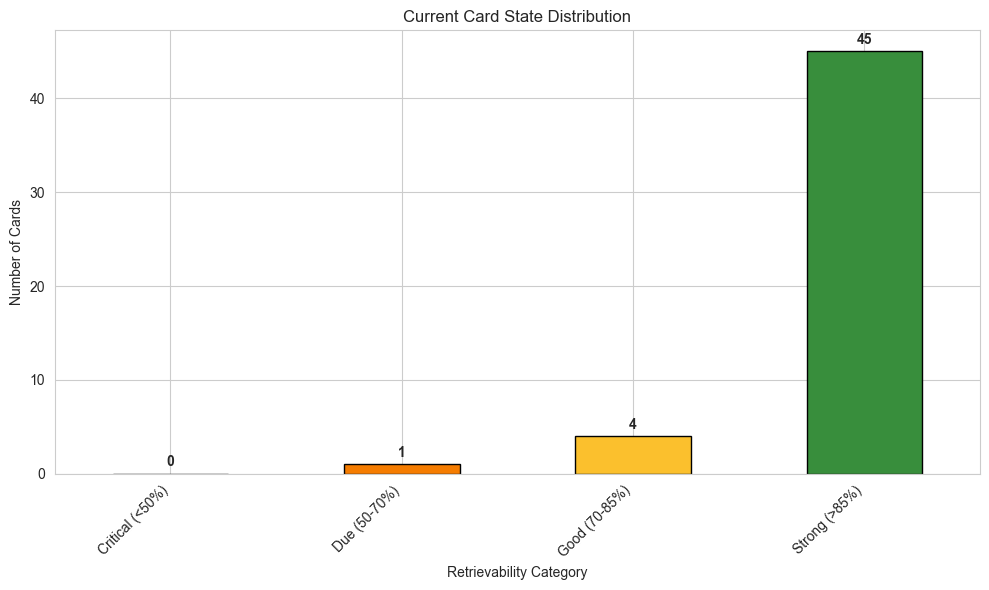


Cards needing review (R < 70%): 1


In [10]:
# Bin retrievability into categories
cards_df['r_category'] = pd.cut(cards_df['retrievability'], 
                                 bins=[0, 0.5, 0.7, 0.85, 1.0],
                                 labels=['Critical (<50%)', 'Due (50-70%)', 
                                        'Good (70-85%)', 'Strong (>85%)'])

r_counts = cards_df['r_category'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#d32f2f', '#f57c00', '#fbc02d', '#388e3c']
r_counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('Retrievability Category')
ax.set_ylabel('Number of Cards')
ax.set_title('Current Card State Distribution')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add counts on bars
for i, v in enumerate(r_counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nCards needing review (R < 70%): {(cards_df['retrievability'] < 0.7).sum()}")

# Load review events (updated schema)
events_df = pd.read_sql_query("""
    SELECT 
        timestamp,
        word_id,
        lemma,
        pos,
        feedback_grade,
        latency_ms,
        stability_before,
        difficulty_before,
        stability_after,
        difficulty_after,
        is_ltm_event
    FROM review_events
    WHERE exercise_type = 'word_translation'
    ORDER BY timestamp
""", conn)

events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])
events_df['date'] = events_df['timestamp'].dt.date
events_df['hour'] = events_df['timestamp'].dt.hour

# Reviews per day
daily_reviews = events_df.groupby('date').size()

fig, ax = plt.subplots(figsize=(12, 5))
daily_reviews.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Reviews')
ax.set_title('Daily Review Activity')
ax.axhline(daily_reviews.mean(), color='red', linestyle='--', 
           label=f'Average: {daily_reviews.mean():.1f} reviews/day')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Total reviews: {len(events_df)}")
print(f"Days active: {len(daily_reviews)}")
print(f"Average reviews per day: {daily_reviews.mean():.1f}")
print(f"LTM events: {events_df['is_ltm_event'].sum()}")
print(f"STM events: {(1 - events_df['is_ltm_event']).sum()}")

In [ ]:
## LTM vs STM Analysis

How are reviews split between long-term memory (LTM) and short-term memory (STM)?

# LTM vs STM event breakdown
event_type_counts = events_df.groupby('is_ltm_event').size()
event_labels = ['STM Events', 'LTM Events']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
event_type_counts.plot(kind='bar', ax=ax1, color=['#2196F3', '#4CAF50'], edgecolor='black')
ax1.set_xlabel('Event Type')
ax1.set_ylabel('Count')
ax1.set_title('LTM vs STM Events')
ax1.set_xticklabels(event_labels, rotation=0)

# Pie chart
ax2.pie(event_type_counts, labels=event_labels, autopct='%1.1f%%', 
        colors=['#2196F3', '#4CAF50'], startangle=90)
ax2.set_title('Event Type Distribution')

plt.tight_layout()
plt.show()

print(f"STM (short-term) reviews: {(events_df['is_ltm_event'] == 0).sum()}")
print(f"LTM (long-term) reviews: {(events_df['is_ltm_event'] == 1).sum()}")
print(f"\nNote: STM reviews are within-session repetitions.")
print(f"LTM reviews update memory parameters based on spaced repetition.")

In [ ]:
## Feedback Grade Distribution

How often do you select Again vs Easy?

# Map feedback grades
grade_map = {1: 'Again', 2: 'Hard', 3: 'Medium', 4: 'Easy'}
events_df['grade_name'] = events_df['feedback_grade'].map(grade_map)

grade_counts = events_df['grade_name'].value_counts().reindex(['Again', 'Hard', 'Medium', 'Easy'], fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors_grade = ['#d32f2f', '#f57c00', '#1976d2', '#388e3c']
grade_counts.plot(kind='bar', ax=ax1, color=colors_grade, edgecolor='black')
ax1.set_xlabel('Feedback Grade')
ax1.set_ylabel('Count')
ax1.set_title('Feedback Grade Distribution')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Pie chart
ax2.pie(grade_counts, labels=grade_counts.index, autopct='%1.1f%%', 
        colors=colors_grade, startangle=90)
ax2.set_title('Feedback Grade Proportions')

plt.tight_layout()
plt.show()

# Calculate success rate (anything other than Again)
success_rate = (events_df['feedback_grade'] > 1).mean() * 100
print(f"\nSuccess rate (non-Again): {success_rate:.1f}%")

In [ ]:
## Problem Words - Hardest to Remember

Identify words that need extra attention

# Find words with highest difficulty or lowest stability
problem_words = cards_df.nlargest(10, 'difficulty')[['lemma', 'pos', 'difficulty', 'stability', 'retrievability', 'review_count']]

print("Top 10 Hardest Words (by difficulty):")
print(problem_words.to_string(index=False))
print()

# Words with lowest stability (forgotten quickly)
unstable_words = cards_df[cards_df['review_count'] >= 3].nsmallest(10, 'stability')[['lemma', 'pos', 'stability', 'difficulty', 'review_count']]
if len(unstable_words) > 0:
    print("\nMost Unstable Words (reviewed 3+ times, lowest stability):")
    print(unstable_words.to_string(index=False))
else:
    print("\nNot enough cards with 3+ reviews for stability analysis.")

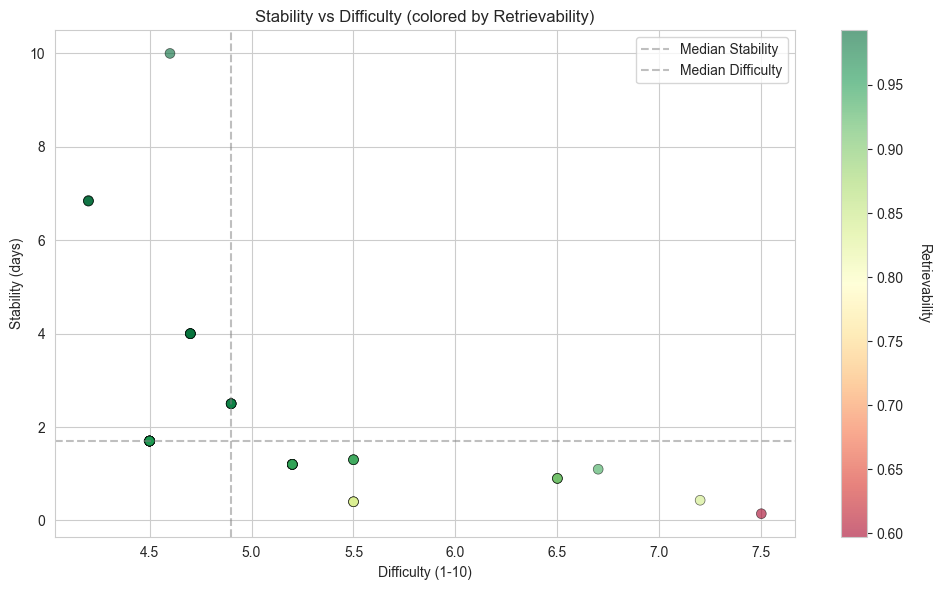

Correlation between difficulty and stability: -0.509
→ Harder words tend to have lower stability (forgotten faster)


In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(cards_df['difficulty'], cards_df['stability'], 
                     c=cards_df['retrievability'], cmap='RdYlGn', 
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Difficulty (1-10)')
ax.set_ylabel('Stability (days)')
ax.set_title('Stability vs Difficulty (colored by Retrievability)')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Retrievability', rotation=270, labelpad=20)

# Add reference lines
ax.axhline(cards_df['stability'].median(), color='gray', linestyle='--', alpha=0.5, label='Median Stability')
ax.axvline(cards_df['difficulty'].median(), color='gray', linestyle='--', alpha=0.5, label='Median Difficulty')
ax.legend()

plt.tight_layout()
plt.show()

# Correlation
correlation = cards_df['difficulty'].corr(cards_df['stability'])
print(f"Correlation between difficulty and stability: {correlation:.3f}")
if correlation < -0.3:
    print("→ Harder words tend to have lower stability (forgotten faster)")
elif correlation > 0.3:
    print("→ Harder words tend to have higher stability (unexpected!)")
else:
    print("→ Difficulty and stability are weakly correlated")

## 8. Learning Curve - Stability Over Review Count

Does stability improve with more reviews?

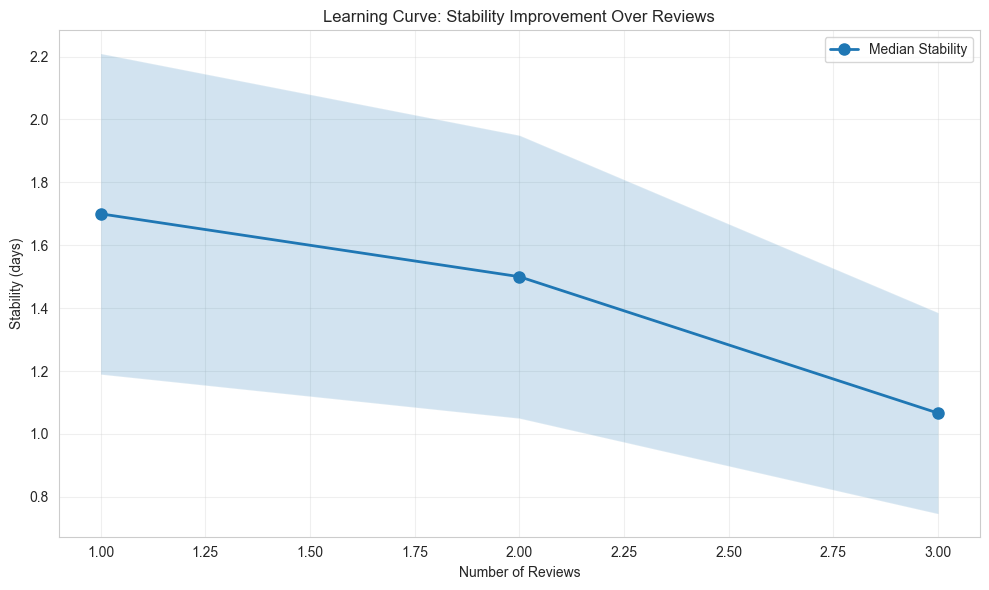

Stability by review count:
                median      mean  count
review_count                           
1             1.700000  1.916667     36
2             1.500000  3.298599     10
3             1.066038  2.278691      4


In [15]:
# Group by review count and plot median stability
learning_curve = cards_df.groupby('review_count')['stability'].agg(['median', 'mean', 'count'])
learning_curve = learning_curve[learning_curve['count'] >= 3]  # Only show counts with 3+ cards

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(learning_curve.index, learning_curve['median'], marker='o', 
        label='Median Stability', linewidth=2, markersize=8)
ax.fill_between(learning_curve.index, 
                learning_curve['median'] * 0.7, 
                learning_curve['median'] * 1.3, 
                alpha=0.2)

ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Stability (days)')
ax.set_title('Learning Curve: Stability Improvement Over Reviews')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Stability by review count:")
print(learning_curve)

## 9. Time of Day Analysis

When do you study most?

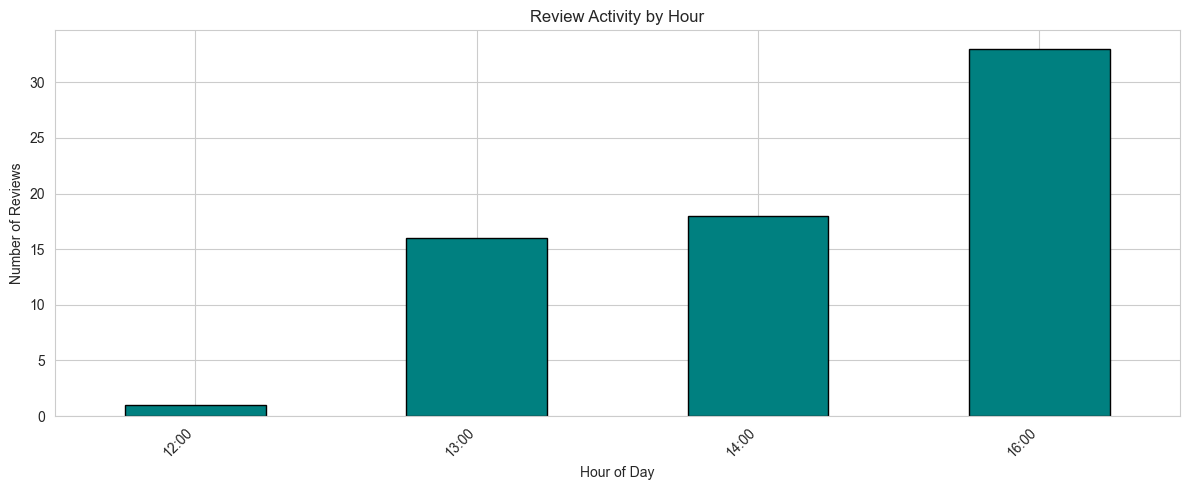

Peak study hour: 16:00 (33 reviews)


In [16]:
hourly_reviews = events_df.groupby('hour').size()

fig, ax = plt.subplots(figsize=(12, 5))
hourly_reviews.plot(kind='bar', ax=ax, color='teal', edgecolor='black')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Reviews')
ax.set_title('Review Activity by Hour')
ax.set_xticklabels([f'{h}:00' for h in hourly_reviews.index], rotation=45, ha='right')

plt.tight_layout()
plt.show()

peak_hour = hourly_reviews.idxmax()
print(f"Peak study hour: {peak_hour}:00 ({hourly_reviews[peak_hour]} reviews)")

## 10. Response Time Analysis

How quickly do you answer?

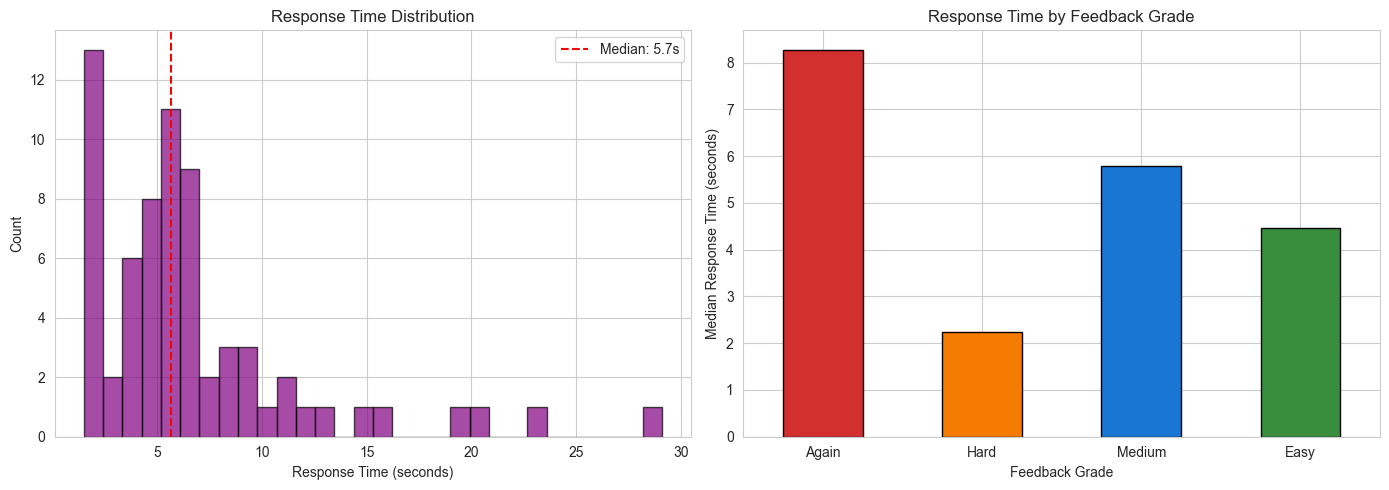

Median response time: 5.7s
Mean response time: 6.7s


In [17]:
# Filter out nulls and convert to seconds
events_with_latency = events_df[events_df['latency_ms'].notna()].copy()
events_with_latency['latency_sec'] = events_with_latency['latency_ms'] / 1000

if len(events_with_latency) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Overall distribution
    ax1.hist(events_with_latency['latency_sec'], bins=30, edgecolor='black', alpha=0.7, color='purple')
    ax1.axvline(events_with_latency['latency_sec'].median(), color='red', linestyle='--',
                label=f'Median: {events_with_latency["latency_sec"].median():.1f}s')
    ax1.set_xlabel('Response Time (seconds)')
    ax1.set_ylabel('Count')
    ax1.set_title('Response Time Distribution')
    ax1.legend()
    
    # By feedback grade
    latency_by_grade = events_with_latency.groupby('grade_name')['latency_sec'].median().reindex(['Again', 'Hard', 'Medium', 'Easy'])
    latency_by_grade.plot(kind='bar', ax=ax2, color=colors_grade, edgecolor='black')
    ax2.set_xlabel('Feedback Grade')
    ax2.set_ylabel('Median Response Time (seconds)')
    ax2.set_title('Response Time by Feedback Grade')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Median response time: {events_with_latency['latency_sec'].median():.1f}s")
    print(f"Mean response time: {events_with_latency['latency_sec'].mean():.1f}s")
else:
    print("No latency data available yet.")

import numpy as np

# Pick 5 random words to visualize
sample_words = cards_df.sample(min(5, len(cards_df)))

fig, ax = plt.subplots(figsize=(12, 6))

# Plot forgetting curve for each word
days_future = np.linspace(0, 30, 100)

for _, word in sample_words.iterrows():
    # FSRS formula: R = exp(-Δt / S)
    retrievability = [math.exp(-d / word['stability']) for d in days_future]
    label = f"{word['lemma']} (S={word['stability']:.1f}d, D={word['difficulty']:.1f})"
    ax.plot(days_future, retrievability, label=label, linewidth=2)

ax.axhline(0.7, color='red', linestyle='--', alpha=0.5, label='Review threshold (70%)')
ax.set_xlabel('Days Since Review')
ax.set_ylabel('Retrievability')
ax.set_title('Forgetting Curves (Sample Words) - Using FSRS formula: R = exp(-Δt/S)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

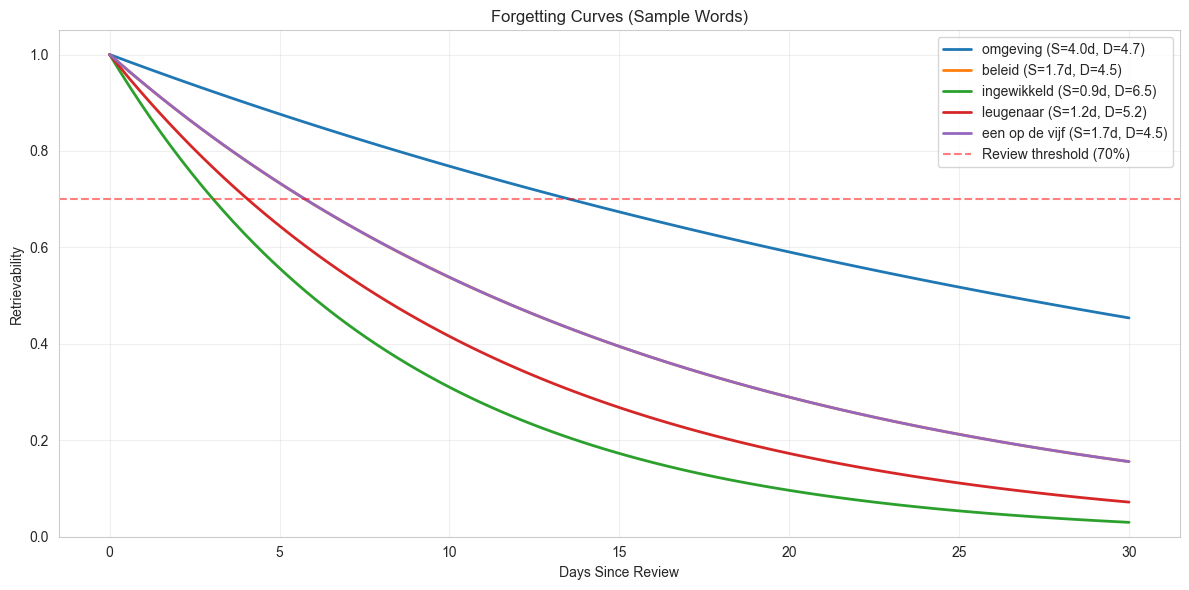

In [18]:
import numpy as np

# Pick 5 random words to visualize
sample_words = cards_df.sample(min(5, len(cards_df)))

fig, ax = plt.subplots(figsize=(12, 6))

# Plot forgetting curve for each word
days_future = np.linspace(0, 30, 100)

for _, word in sample_words.iterrows():
    retrievability = [0.9 ** (d / word['stability']) for d in days_future]
    label = f"{word['lemma']} (S={word['stability']:.1f}d, D={word['difficulty']:.1f})"
    ax.plot(days_future, retrievability, label=label, linewidth=2)

ax.axhline(0.7, color='red', linestyle='--', alpha=0.5, label='Review threshold (70%)')
ax.set_xlabel('Days Since Review')
ax.set_ylabel('Retrievability')
ax.set_title('Forgetting Curves (Sample Words)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

## 12. Export Summary Report

In [ ]:
# Calculate metrics for summary
avg_reviews_per_day = daily_reviews.mean() if len(events_df) > 0 else 0
days_active_count = len(daily_reviews) if len(events_df) > 0 else 0

summary = f"""
=== Dutch Learning Summary ===
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}

OVERALL PROGRESS:
- Total cards learned: {len(cards_df)}
- Total reviews: {len(events_df)}
- Days active: {days_active_count}
- Average reviews/day: {avg_reviews_per_day:.1f}

RETENTION METRICS:
- Average stability: {cards_df['stability'].mean():.2f} days
- Median stability: {cards_df['stability'].median():.2f} days
- Average difficulty: {cards_df['difficulty'].mean():.2f}/10
- Median difficulty: {cards_df['difficulty'].median():.2f}/10

CURRENT STATE:
- Cards due (R < 70%): {(cards_df['retrievability'] < 0.7).sum()}
- Cards strong (R > 85%): {(cards_df['retrievability'] > 0.85).sum()}
- Average retrievability: {cards_df['retrievability'].mean():.1%}

PERFORMANCE:
- Success rate: {success_rate:.1f}% (non-Again responses)
- Again: {grade_counts.get('Again', 0)} ({grade_counts.get('Again', 0)/len(events_df)*100:.1f}%)
- Hard: {grade_counts.get('Hard', 0)} ({grade_counts.get('Hard', 0)/len(events_df)*100:.1f}%)
- Medium: {grade_counts.get('Medium', 0)} ({grade_counts.get('Medium', 0)/len(events_df)*100:.1f}%)
- Easy: {grade_counts.get('Easy', 0)} ({grade_counts.get('Easy', 0)/len(events_df)*100:.1f}%)
"""

print(summary)

# Optionally save to file
with open('learning_summary.txt', 'w') as f:
    f.write(summary)
print("\n✓ Summary saved to learning_summary.txt")

In [ ]:
# Close connection
conn.close()